# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [1]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os
import operator

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec


from keras.preprocessing.sequence import pad_sequences

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

Using TensorFlow backend.


# 1. Import and Clean Data

In [2]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),5000)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [3]:
review['rating_normed'] = review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']= (review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

In [30]:
review['rating'] = review['rating'].apply(round)

# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

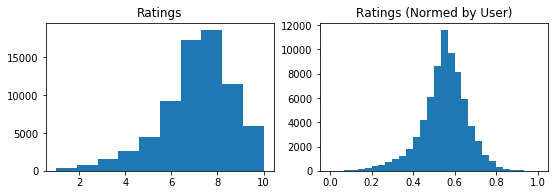

In [4]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=30)
plt.title('Ratings (Normed by User)');

## _TextBlob_

# 3. Tokenize

In [5]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


comments_train = list(review["comment"].fillna("NAN_WORD").values)

review['token'] = process_comments(comments_train, lower=True)

Processing text dataset


100%|██████████| 71940/71940 [00:03<00:00, 22795.87it/s]


In [6]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 36366 unique tokens


# 4. Vectorize

In [7]:
model = Word2Vec(review['token'], size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
vec_size = model.layer1_size
word_vectors = model.wv

In [8]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 11877


In [9]:
model.wv.most_similar_cosmul(positive=['paper', 'board'], negative=['box'])

[('focusing', 1.012260913848877),
 ('fly', 0.9735428094863892),
 ('rely', 0.9723181128501892),
 ('stealing', 0.9596307873725891),
 ('programmed', 0.9525526762008667),
 ('relying', 0.9505840539932251),
 ('territory', 0.9498519897460938),
 ('basis', 0.9439877271652222),
 ('focused', 0.9417085647583008),
 ('rondel', 0.9356568455696106)]

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

# 4. Word Embedding

In [10]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [11]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [12]:
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in review['token']]

In [35]:
# pad
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
y = pd.get_dummies(review['rating']).values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (71940, 200)
Shape of label tensor: (71940, 10)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

# 5. Models

In [39]:
from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [40]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

In [41]:
# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [42]:
embedded_sequences = wv_layer(comment_input)

In [43]:
# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

In [44]:
# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(10, activation='sigmoid')(x)

In [135]:
# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['categorical_accuracy'])

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          1187700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [56]:
hist = model.fit(X_train, y_train, validation_split=0.1,
                 epochs=3, verbose=1,batch_size=256, shuffle=True)

Train on 43379 samples, validate on 4820 samples
Epoch 1/3
43379/43379 [==============================] - 126s 3ms/step - loss: 0.2505 - categorical_accuracy: 0.3563 - val_loss: 0.2518 - val_categorical_accuracy: 0.3402
Epoch 2/3
43379/43379 [==============================] - 142s 3ms/step - loss: 0.2491 - categorical_accuracy: 0.3566 - val_loss: 0.2506 - val_categorical_accuracy: 0.3398
Epoch 3/3
43379/43379 [==============================] - 127s 3ms/step - loss: 0.2478 - categorical_accuracy: 0.3597 - val_loss: 0.2498 - val_categorical_accuracy: 0.3392


In [57]:
score = model.evaluate(X_test, y_test, verbose=0)

In [58]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25126715349089573
Test accuracy: 0.3455625289332359


In [61]:
predict = model.predict(X_test)

In [96]:
def convert_to_one(p):
    new_p =[]
    for values in p:
        l = []
        max_index, max_value = max(enumerate(values), key=operator.itemgetter(1))

        for m in range(len(values)):
            if m!=max_index:
                l.append(0)
            else:
                l.append(1)
        new_p.append(l)
        
    return new_p

In [113]:
pred = np.array(convert_to_one(predict))
dummies = pd.get_dummies(review['rating'])[0:0]
for i in range(len(pred)):
    dummies.loc[i] = pred[i]
    
pred_ratings = pd.Series(dummies.columns[np.where(dummies!=0)[1]])

In [119]:
dummies = pd.get_dummies(review['rating'])[0:0]
for i in range(len(y_test)):
    dummies.loc[i] = y_test[i]
y_test_ratings = pd.Series(dummies.columns[np.where(dummies!=0)[1]])

In [125]:
from keras.backend import argmax as kargmax
y_predict = np.argmax(predict,axis=1)
y_actual = np.argmax(y_test,axis=1)

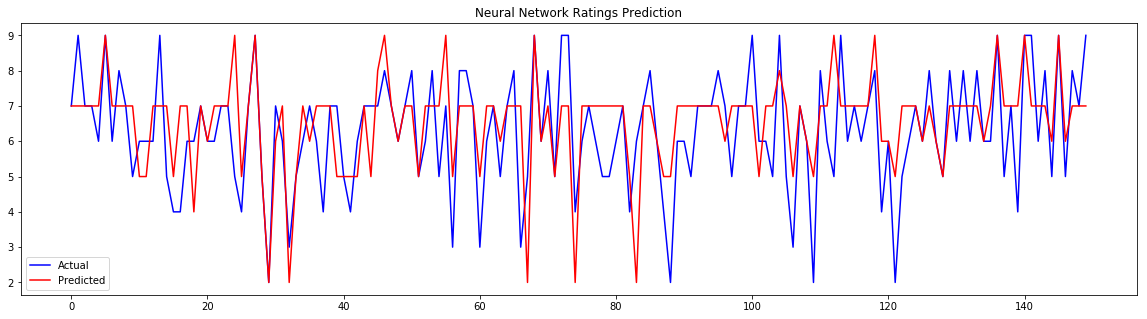

In [126]:
plt.figure(figsize=(20,5))
plt.plot(y_actual[0:150],color='b')
plt.plot(y_predict[0:150],color='r')
plt.title('Neural Network Ratings Prediction')
plt.legend(['Actual','Predicted'])
plt.show()

In [129]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):
    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

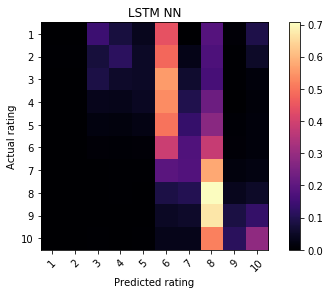

In [131]:
plot_confusion(y_actual,y_predict,'LSTM NN')

## _Root Mean Squared Error_

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [127]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))
# print('Root Mean Squared Error: {}'.format(RMSE))

In [128]:
print(RMSE)

1.5374383814917174
